# Mapping AOIs

Map AOIs and show them.

## Import packages

In [77]:
import os
import math
import pandas as pd
import numpy as np
import requests
from io import StringIO
import keplergl
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from keplergl import KeplerGl
from matplotlib_scalebar.scalebar import ScaleBar

## Read the boundary file

<AxesSubplot:>

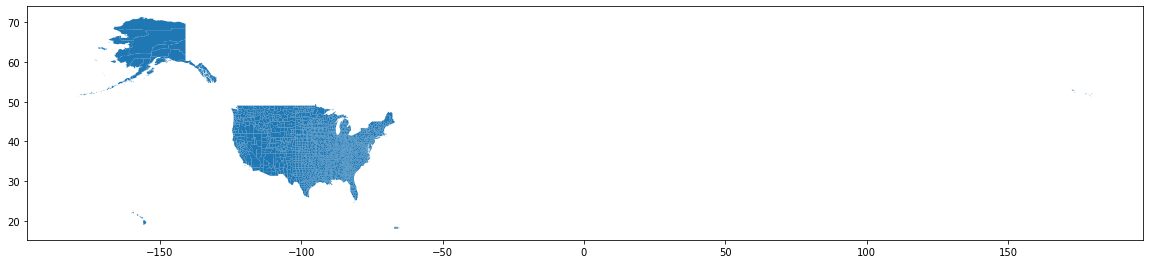

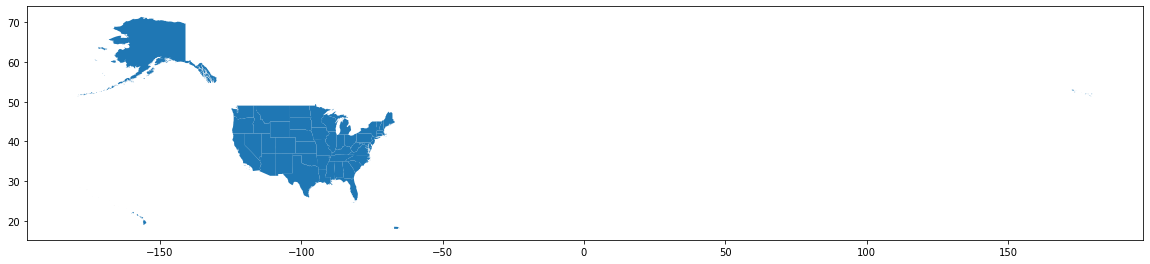

In [112]:
boundary_file = r'county_shp\us_counties.shp'
state_file = r'gz_2010_us_040_00_500k.json'
# sFile = open(boundary_file,"r")

gdf = gpd.read_file(boundary_file)
state_gdf = gpd.read_file(state_file)

gdf.plot(figsize=(20, 10))

state_gdf.plot(figsize=(20, 10))

Filter AOIs

<AxesSubplot:>

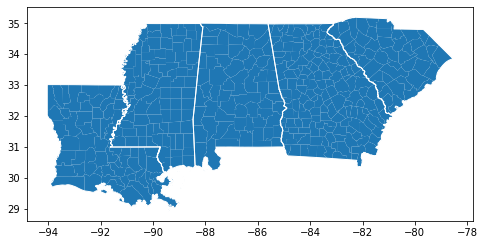

In [123]:
target_file = r'Plot_CID.csv'
target_df = pd.read_csv(target_file)
target_df['fips'] = target_df['fips'].astype(str)
target_df['fips'] = target_df['fips'].str.zfill(5)

gdf['fips'] = gdf['GEO_ID'].str[-5:]


AOI_gdf = gdf[gdf['fips'].isin(target_df['fips'].to_list())]
AOI_state_gdf = state_gdf[state_gdf['STATE'].isin(target_df['fips'].str[:2])]

# AOI_gdf = pd.merge(AOI_gdf, target_df, left_on='fips', right_on="fips")
ax = AOI_gdf.plot(figsize=(8, 4))

AOI_state_gdf.plot(ax=ax, figsize=(8, 4), facecolor="none", edgecolor="white")

## Map AOIs in a figure

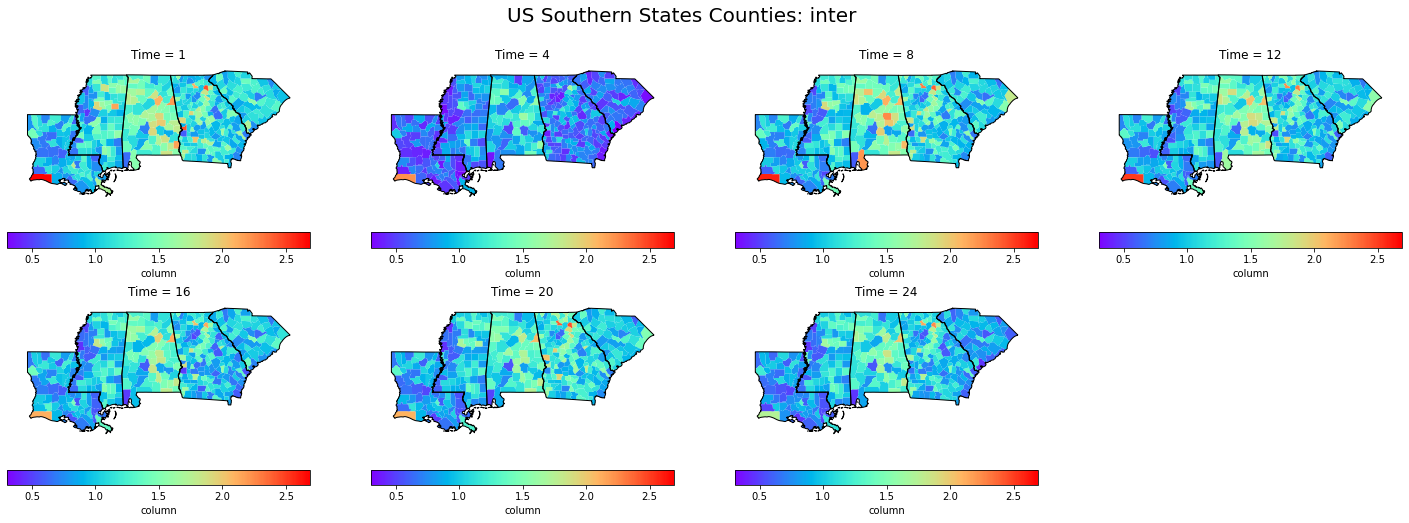

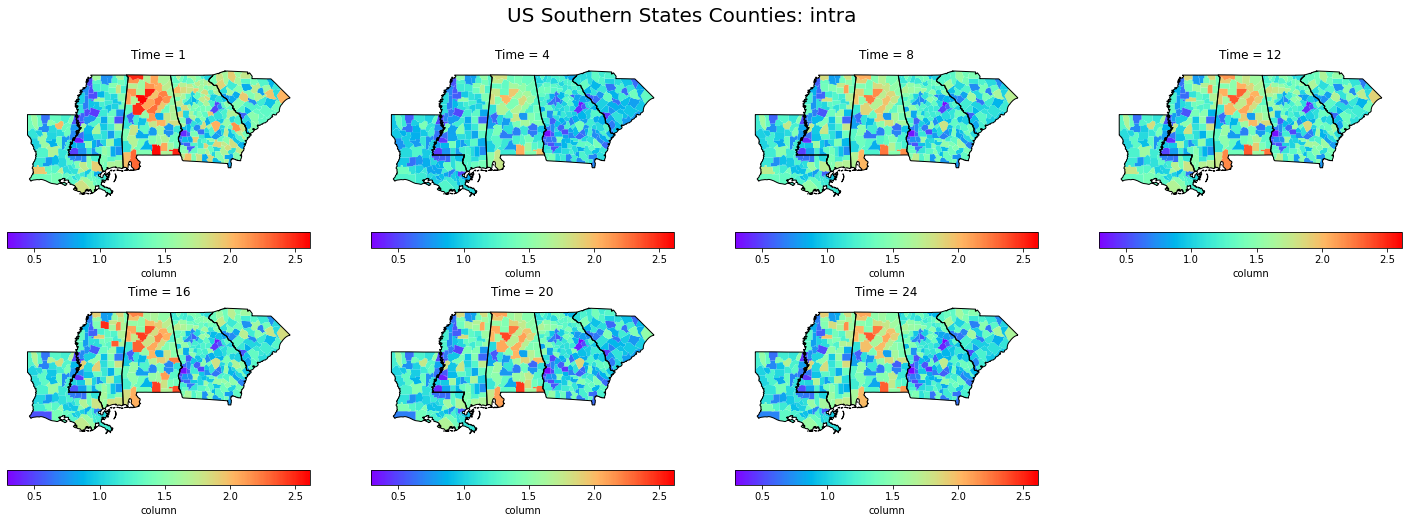

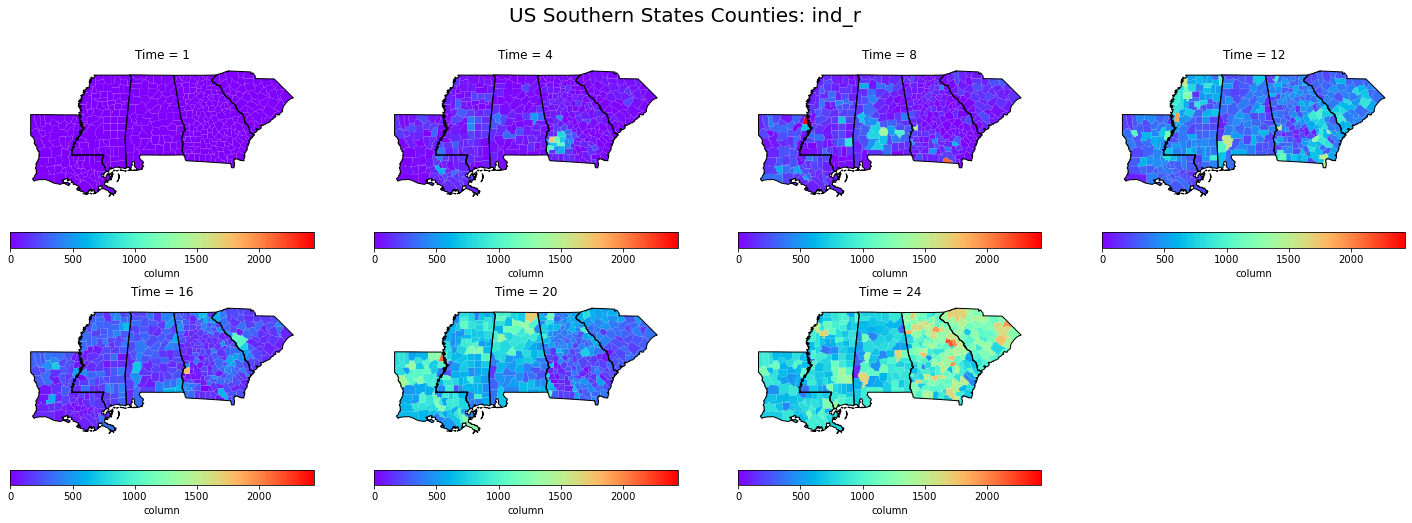

In [129]:
from matplotlib_scalebar.scalebar import ScaleBar

row_cnt = 2
col_cnt = 4


map_columns = ['inter', 'intra', 'ind_r']
time_interval_colum = r'time'
time_intervals = target_df[time_interval_colum].unique()

for idx, column in enumerate(map_columns):
    
    fig, axes = plt.subplots(row_cnt, col_cnt, figsize=(25,8))
    fig.suptitle(f"US Southern States Counties: {column}", fontsize=20) 
    for i in range(idx + 1, col_cnt * row_cnt, 1):
        axes[divmod(i, col_cnt)].axis('off')

    # find the range of changes    
    vmin= target_df[column].min()
    vmax= target_df[column].max()

    # draw suplots
    for idx2, time_itvl in enumerate(time_intervals):
        
        time_df = target_df[target_df['time'] == time_itvl]
        
        axes[divmod(idx2, col_cnt)].axis('off')
        

        merged_df = pd.merge(AOI_gdf, time_df, left_on='fips', right_on="fips")
        
        ax = merged_df.plot(column=merged_df[column], 
                cmap='rainbow',  
                ax=axes[divmod(idx2, col_cnt)], 
                legend=True, 
                legend_kwds={'label': f'{column}',
                             'orientation': "horizontal"},
                vmin=vmin,
                vmax=vmax,                       
               )
        axes[divmod(idx2, col_cnt)].set_title(f"Time = {time_itvl}")
        AOI_state_gdf.plot(ax=ax, facecolor="none", edgecolor="black")
        
#         axes[divmod(idx2, col_cnt)].add_artist(ScaleBar(1))
#     plt.show()
    plt.savefig(f"US_Southern_States_Counties_{column}_no_colorbar.png", dpi=254)

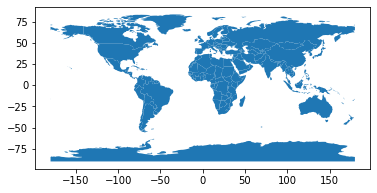

In [110]:
import geopandas
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world.plot()

import matplotlib.pyplot as plt
plt.savefig('world.jpg')

<AxesSubplot:>

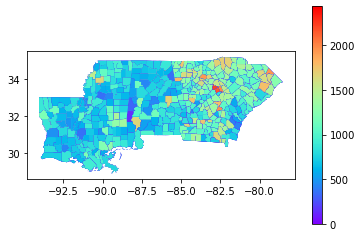

In [39]:
AOI_gdf.plot(column=AOI_gdf['ind_r'], 
        cmap='rainbow',  
        legend=True, 
                     
       )

In [73]:
!pip install matplotlib-scalebar

## obtain 2020 flow data using REST APIs of ODT Explorer

In [146]:
params = {"operation": "get_daily_movement_for_all_places",
          "scale": "world_first_level_admin",
          "source": "twitter",
          "begin": "01/01/2019",
          "end": "12/31/2019"
      }

q = r'http://gis.cas.sc.edu/GeoAnalytics/REST'
r = requests.get(q, params=params)
df = pd.read_csv(StringIO(r.text))

# extract flows of the target place
df = df[df['place'].str[:3] == target_place]

# replace place codes with place names
df = pd.merge(df, gdf_country[['GID_1', "NAME_1"]], left_on='place', right_on="GID_1")
df['place'] = df['NAME_1']
df = df.drop(["NAME_1", "GID_1"], axis=1)

df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
df

,place,intra_movement
date,,
2019-01-01,Nouvelle-Aquitaine,196
2019-01-02,Nouvelle-Aquitaine,206
2019-01-03,Nouvelle-Aquitaine,219
2019-01-04,Nouvelle-Aquitaine,226
2019-01-05,Nouvelle-Aquitaine,221
...,...,...
2019-12-26,Normandie,127
2019-12-27,Normandie,119
2019-12-28,Normandie,133


## Draw a map showing the monthly change compared with January

Group the monthly flows of each administrative region.

In [147]:
groupped = df.groupby([pd.Grouper(freq='M'), 'place'] )['intra_movement'].sum().to_frame()
groupped

intra_movement
date       place                                     
2019-01-31 Auvergne-Rhône-Alpes                  9048
           Bourgogne-Franche-Comté               2022
           Bretagne                              2995
           Centre-Val de Loire                   2928
           Corse                                  723
...                                               ...
2019-12-31 Nouvelle-Aquitaine                    6992
           Occitanie                             7126
           Pays de la Loire                      3962
           Provence-Alpes-Côte d'Azur            7880
           Île-de-France                        53356

[156 rows x 1 columns]

Extract the flows of January

In [148]:
dates = groupped.index.get_level_values("date").unique()
jan_data = groupped.loc[dates[0]]   ## dates[0].strftime("%Y-%m-%d")
jan_data

,intra_movement
place,
Auvergne-Rhône-Alpes,9048
Bourgogne-Franche-Comté,2022
Bretagne,2995
Centre-Val de Loire,2928
Corse,723
Grand Est,7807
Hauts-de-France,11827
Normandie,4171
Nouvelle-Aquitaine,6279


Show the map.

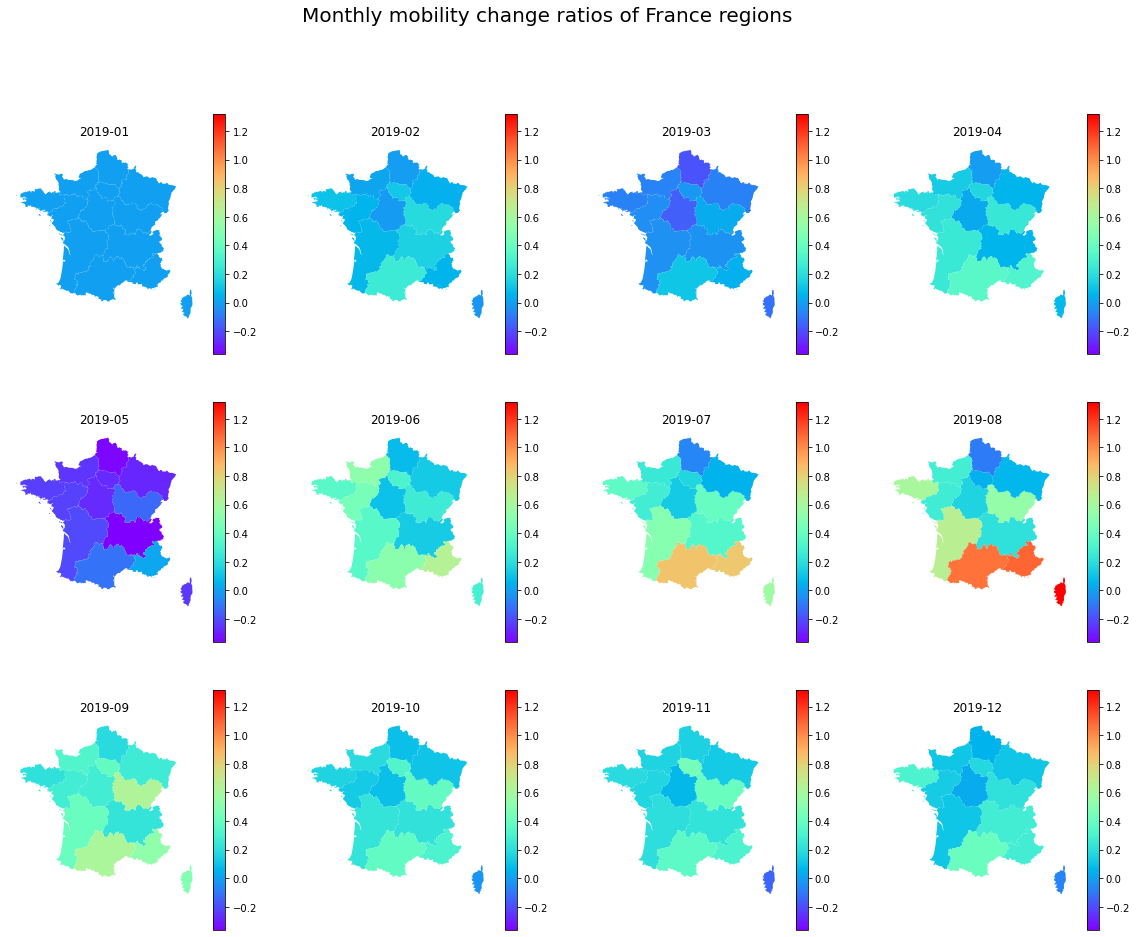

In [149]:
row_cnt = 3
col_cnt = 4
fig, axes = plt.subplots(row_cnt, col_cnt, figsize=(20,15))
fig.suptitle("Monthly mobility change ratios of France regions", fontsize=20) 


# find the range of monthly changes
changes = groupped.groupby(level=[0, 1])['intra_movement'].sum() / jan_data['intra_movement']- 1
vmin= min(changes)
vmax= max(changes)

# draw suplots
for idx, date in enumerate(dates):
    month_df = groupped.loc[date]
    axes[divmod(idx, col_cnt)].axis('off')

    month_df['adjusted'] = (month_df['intra_movement'].to_list() - jan_data['intra_movement']) / jan_data['intra_movement']

    re = gdf_country.set_index('NAME_1').join(month_df, how='left')
    re.plot(column=re['adjusted'], 
            cmap='rainbow',  
            ax=axes[divmod(idx, col_cnt)], 
            legend=True, 
            vmin=vmin,
            vmax=vmax,                       
           )
    axes[divmod(idx, col_cnt)].set_title(date.strftime("%Y-%m"))

plt.show()

## Plot the monthly data

Plot all regions together

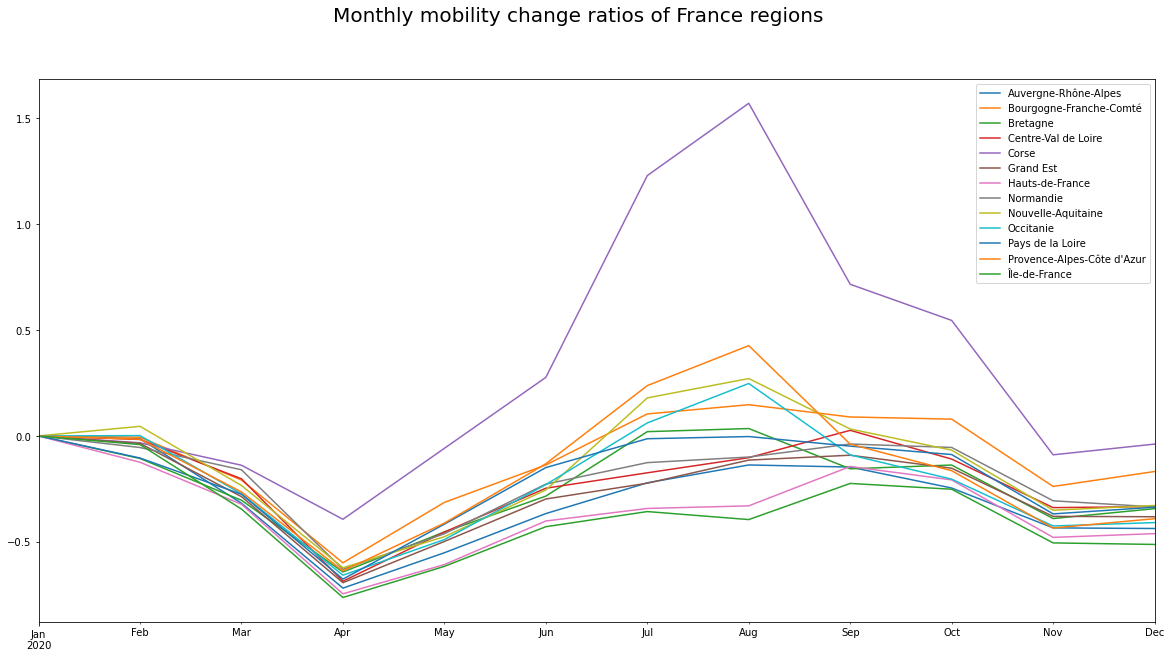

In [141]:
groupped = df.groupby([pd.Grouper(freq='M'), 'place'], as_index=True )['intra_movement'].sum().to_frame()
changes = groupped.groupby(level=[0, 1])['intra_movement'].sum() / jan_data['intra_movement']- 1

fig, ax = plt.subplots()
fig.suptitle("Monthly mobility change ratios of France regions", fontsize=20) 
ax = changes.unstack(level=1).plot(figsize=(20, 10), ax=ax)
ax.set(xlabel="")
ax.legend(groupped.unstack(level=1).columns.get_level_values(1));

Plot  regions individually

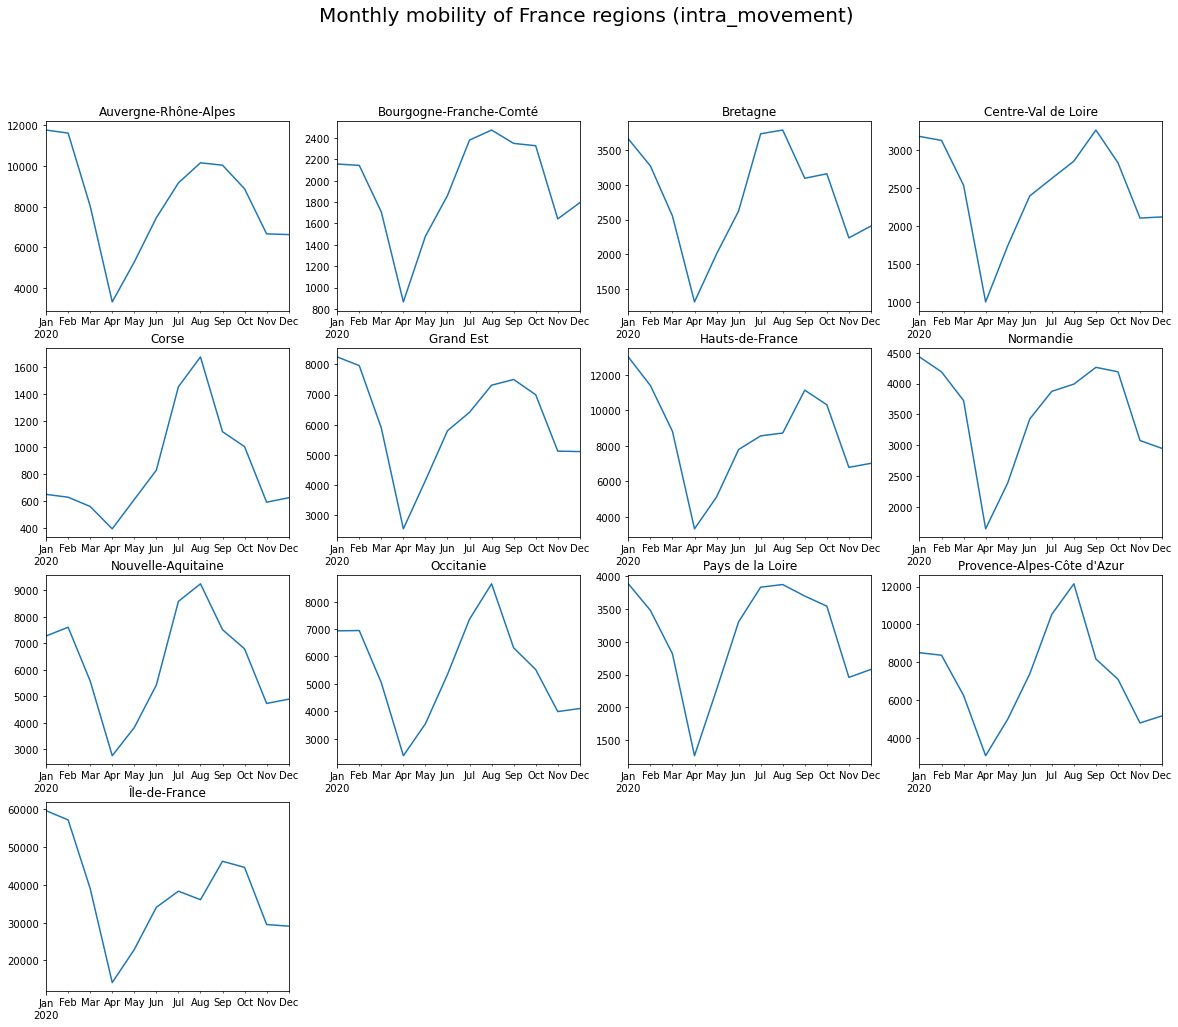

In [145]:
groupped = df.groupby([pd.Grouper(freq='M'), 'place'] )['intra_movement'].sum().to_frame()
groupped = groupped.reorder_levels(['place', "date"])
places = groupped.index.get_level_values("place").unique()
col_cnt = min(6, math.ceil(math.sqrt(len(places))))
row_cnt = math.ceil(len(places)/col_cnt)
fig, axes = plt.subplots(row_cnt, col_cnt, figsize=(row_cnt * 5, col_cnt * 4) )
fig.suptitle("Monthly mobility of France regions (intra_movement)", fontsize=20) 

for idx, place in enumerate(places):
    day_df = groupped.loc[place]
    ax = day_df.plot(ax=axes[divmod(idx, col_cnt)], title = place, legend=False)
    ax.set_xlabel("")

for i in range(idx + 1, col_cnt * row_cnt, 1):
    axes[divmod(i, col_cnt)].axis('off')

plt.show()